In [1]:
from LIMxCMBL.init import *
from LIMxCMBL.experiments import *

import matplotlib.pyplot as plt
from matplotlib import colors


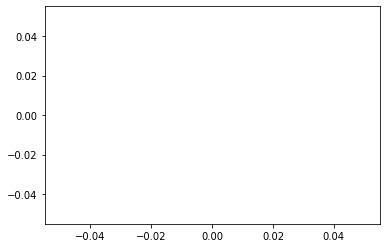

In [2]:
plt.plot()
plt.rcParams.update({
    "text.usetex": True,
    "font.size": "11",
    "font.family" : "serif",
    'figure.constrained_layout.use':True,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'hatch.linewidth':0.1
})

e_order = ['CHIME',
          'HETDEX',
          'COMAP',
           'CCAT-prime',
           'SPHEREx',
]

In [3]:
plt_left = plt.rcParams['figure.subplot.left']
plt_right = plt.rcParams['figure.subplot.right']
plt_cntr = (plt_left + plt_right) / 2

In [4]:
from LIMxCMBL.noise import f_eIeI


In [5]:
_alphas = {
    'CHIME': 150,
    'HETDEX': 400,
    'COMAP': 250,
    'SPHEREx': 250,
    'CCAT-prime': 500,
}

In [6]:
tilde_chi = np.arange(0, 2, 0.001)

def plot_gap(alpha, 
             beta,
             text,
             ax,
            gap_size = 180):
    
    if(alpha >= 1000):
        gap_size = 200
    tilde_chi_prime = beta + tilde_chi

    if np.all(tilde_chi_prime > 1):
        return
    idxs = np.where(tilde_chi_prime <= 1)

    mid_idx = len(tilde_chi[idxs]) // 2
    mid_x = tilde_chi[idxs][mid_idx]
    mid_y = tilde_chi_prime[idxs][mid_idx]
    if((mid_x <= 0.1 or mid_x >= 0.9)):
        return


    ax.plot(tilde_chi[idxs][:mid_idx-gap_size//2], 
            tilde_chi_prime[idxs][:mid_idx-gap_size//2], 
            ls='-',
            c='k', lw=0.25)

    ax.plot(tilde_chi[idxs][mid_idx+gap_size//2:], 
            tilde_chi_prime[idxs][mid_idx+gap_size//2:], 
            ls='-',
            c='k', lw=0.25)


    ax.text(mid_x, mid_y, text, 
            ha='center', va='center', rotation=45, fontsize= 3.8)



In [8]:
import numpy as np

def covariance_to_correlation(covariance_matrix):
    variances = np.diag(covariance_matrix)
    if np.any(variances < 0):
        raise ValueError("negative variances")
    std_devs = np.sqrt(variances)
    
    inv_std_devs = 1 / std_devs
    D_inv = np.diag(inv_std_devs)
    correlation_matrix = D_inv @ covariance_matrix @ D_inv
    np.fill_diagonal(correlation_matrix, 1.0)
    
    return correlation_matrix

/tmp/ipykernel_71535/1514809600.py:3: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad = 0.0)


0 CHIME
1 HETDEX
2 COMAP
3 CCAT-prime
4 SPHEREx


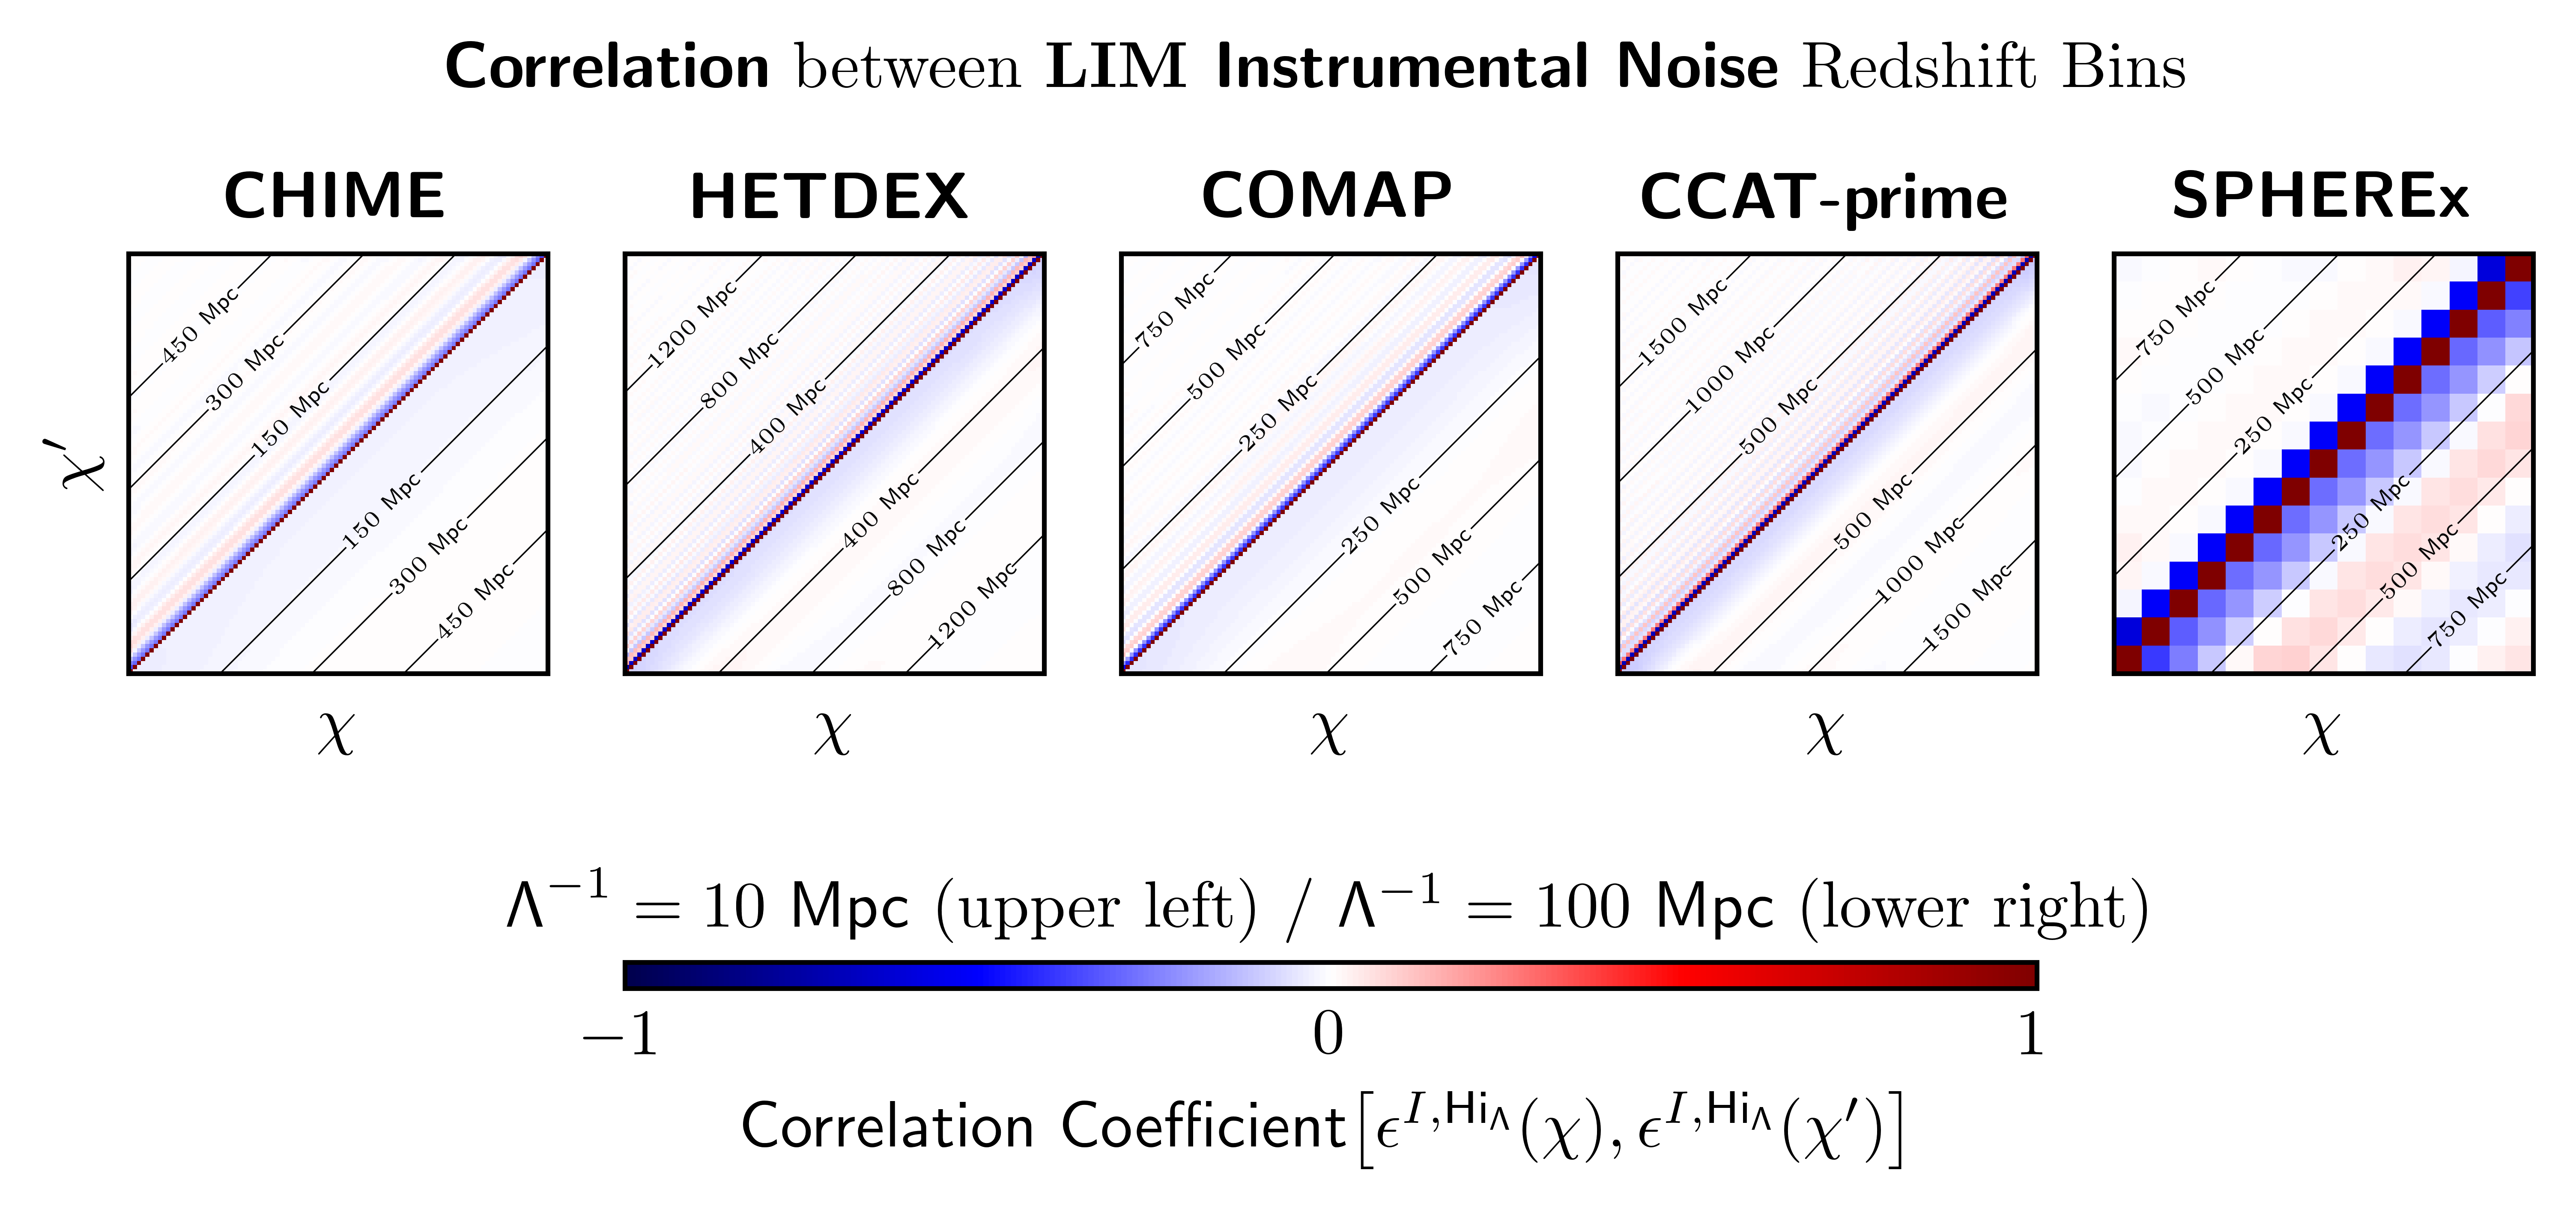

In [24]:
fig, axs = plt.subplots(nrows=1, ncols=5, 
                             figsize = (6, 3.65/3 ), facecolor = 'none', dpi = 1000,sharex=True,sharey=True)
plt.tight_layout(pad = 0.0)



for e_idx, e in enumerate(e_order):
    n_bins = 100
    if(e=='SPHEREx'):
        n_bins = 15
        
        
    print(e_idx, e)
    ax = axs[e_idx]
    
    ax.set_title(r'\textsf{\textbf{%s}}'%(e), fontsize = 11)
    zmin = experiments[e]['zmin']
    zmax = experiments[e]['zmax']
    line_str = experiments[e]['line_str']
    
    Omega_field  =  np.array(experiments[e]['Omega_field'].to(u.rad**2)) #rad^2
    chimin = ccl.comoving_angular_distance(cosmo, 1/(1+zmin))
    chimax = ccl.comoving_angular_distance(cosmo, 1/(1+zmax))
    
    
    chi_bin_edges = np.linspace(chimin*(1+1e-8), chimax*(1 - 1e-8), n_bins + 1)
    chi_bin_centers = (chi_bin_edges[1:] + chi_bin_edges[:-1])/2
    dchi_binned = np.mean(np.diff(chi_bin_edges))

    extent = [0,1,0,1]
    _, Pei = experiments[e]['f_Pei']()
    Pei = np.max(Pei).to(u.Mpc**3  * (u.kJy/u.sr)**2)
    Pei = Pei.value # kJy2 Mpc3 / sr2

    def get_eHIeHI(Lambda_idx):
        eComb_fname = '/scratch/users/delon/LIMxCMBL/eHIeHI/mpmath_comb_'
        eComb_fname +='zmin_%.5f_zmax_%.5f_Lambda_idx_%.d_from_quad_nbins_%d.npy'%(zmin, 
                                                                                   zmax, 
                                                                                   Lambda_idx, 
                                                                                   n_bins)
        eComb = np.load(eComb_fname)
        return Pei * eComb

    eIeI = Pei * np.diag(f_eIeI(chi=chi_bin_centers, dchi=dchi_binned, Lambda=0))
    eHIeHI_10 = get_eHIeHI(24)
    eHIeHI_100 = get_eHIeHI(18)

#     vb1 = np.max(np.abs(eHIeHI_10))
#     vb2 = np.max(np.abs(eHIeHI_100))
    
#     vb = max(vb1, vb2)
#     if(vb2 < vb1):
#         print('vb2 < vb1')
    
#     lin_factor = 1
#     log10vb = np.log10(vb)
#     linthresh = 10**(np.floor(log10vb)-1)
#     vminmax = 10**(log10vb)
    
#     norm = colors.SymLogNorm(linthresh=linthresh, 
#                              linscale=lin_factor,
#                              vmin=-vb, 
#                              vmax=vb, 
#                              base=10)


    
    ax.imshow(covariance_to_correlation(eHIeHI_100),
              vmin=-1,
              vmax=1,
              cmap='seismic',
             extent=extent,
             interpolation = 'none',
             origin = 'lower')
    


    #plot IHiIHi other half
    _eHIeHI_10 = covariance_to_correlation(eHIeHI_10) * np.tri(*eHIeHI_10.shape)
    _eHIeHI_10[np.where(_eHIeHI_10 == 0)] = None

    im = ax.imshow(_eHIeHI_10,
                   vmin=-1,
                   vmax=1,
                   cmap = 'seismic',
                   extent=extent,
                   interpolation = 'none',
                   origin = 'lower')        


    ax.tick_params(axis='both', which='both', length=0)
    ax.set_xticks([])
    ax.set_yticks([])

    ax.set_xlabel(r'$\chi$')

    if(e_idx == 0):
        ax.set_ylabel(r"$\chi'$")


    #plot distance measures
    for i in range(5):
        alpha = (i+1)*_alphas[e] #Mpc
        plot_gap(alpha=alpha,beta=alpha/(chimax-chimin), text = r'%d \textsf{Mpc}'%(np.abs(alpha)), ax=ax)
        plot_gap(alpha=-alpha,beta=-alpha/(chimax-chimin), text = r'%d \textsf{Mpc}'%(np.abs(alpha)), ax=ax)

    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    
#cbar

_bbox = axs[1].get_position()
_bbox2 = axs[2].get_position()

dy_box = _bbox.ymax - _bbox.ymin
dx_box = _bbox.xmax - _bbox.xmin
dx_btwn_box = _bbox2.xmin - _bbox.xmax

cbar_ax = fig.add_axes([_bbox.xmin,
                        _bbox.ymin - 1.5*dy_box/2,
                        (3*dx_box+2*dx_btwn_box), 
                        dy_box/16,],
                      facecolor='none')  # [left, bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax,
                   orientation='horizontal', )
cbar.ax.tick_params(labelsize=11,  direction='out', length=0)
cbar.ax.set_xticks([-1,0,1])


cbar.ax.set_xlabel(r"\textsf{Correlation Coefficient}$\left[\epsilon^{I,{\sf Hi_\Lambda}}(\chi), \epsilon^{I,{\sf Hi_\Lambda}}(\chi')\right]$", fontsize = 11)
cbar.ax.set_title(r'${\sf \Lambda}^{-1}=10$ {\sf Mpc} (upper left) / ${\sf \Lambda}^{-1}=100$ {\sf Mpc}  (lower right)',
                 fontsize=11)
fig.text(plt_cntr, 1.25, r"\textsf{\textbf{Correlation}} between \textbf{LIM \textsf{Instrumental Noise}} Redshift Bins",
         ha='center', 
         va='bottom', 
        fontsize=11)

plt.savefig('figures/013.004.pdf', bbox_inches='tight')